# Lesson 4 - Finite Volume and MUSCL Methods

## Notes:
* we can use the entire control volume itself as a computational cell, rather than trying to use local grid points. 
    * we then can create a volume of size $\Delta x$ instead of $x$ and use that to calculate our points.
    * so we can then use an integral average: $$e_{i} = \frac{1}{\Delta x} = \int_{x_{i}-\frac{\Delta x}{2}}^{x_{i}+\frac{\Delta x}{2}} e(x,t) dx$$
    * This can lead to the differential form of the conservation law, given we know the boundary conditions:
    $$\frac{\partial}{\partial t}e_{i} + \frac{1}{\Delta x}[F(x_{i+\frac{1}{2}},t) - F(x_{i-\frac{1}{2}},t)] = 0$$
    * Due to some handwaving, the CFL limit is 1
    * Godunov's method assumed piecewise constants. MUSCL assumes piecewise functions with discontinuities at the edges (specifically, a straight line. $$e(x) = e{i} + \sigma_{i}(x-x_{i}$$) with $\sigma{i}$ as the minmod function.
        
## Code: 
all the code will follow this cell. This is to ease runtime and to make sure the scope of all variables remains the same. different iterations of the same code with different values or methods of computing the same solution will be in subsquent cells, while code-notes will be commented like usual.


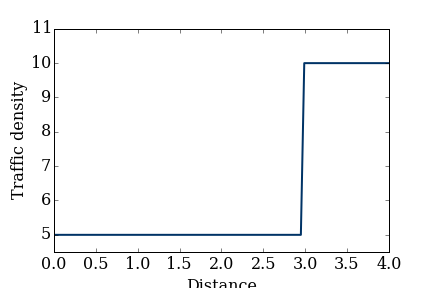
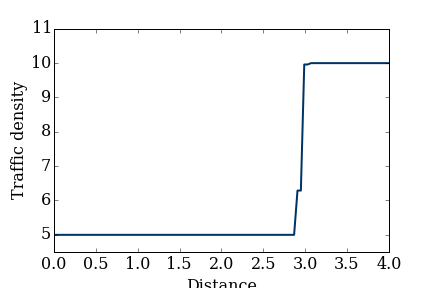
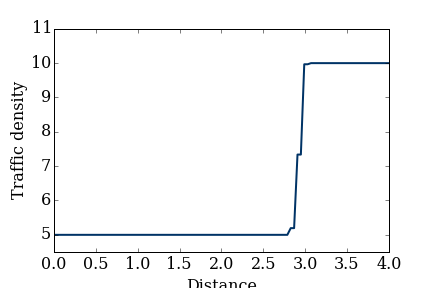
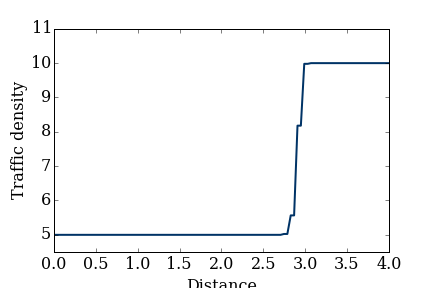
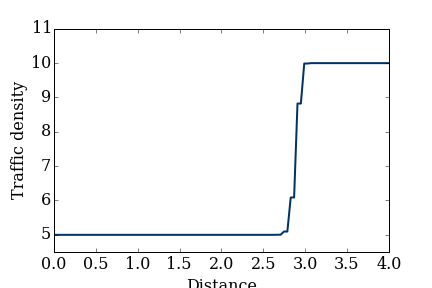
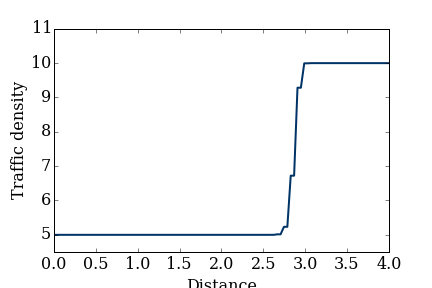
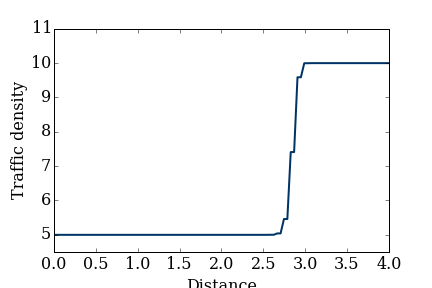
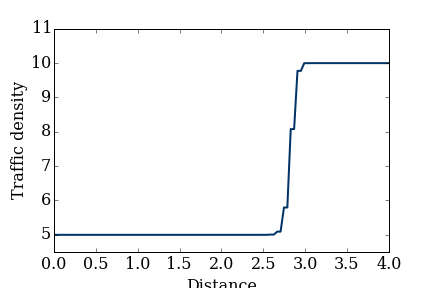
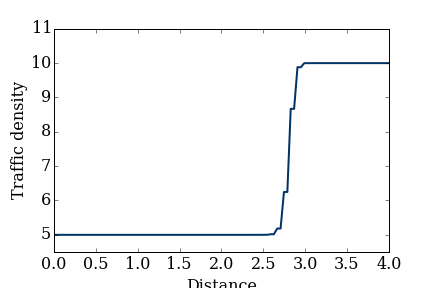
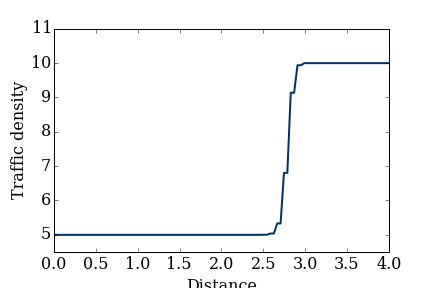
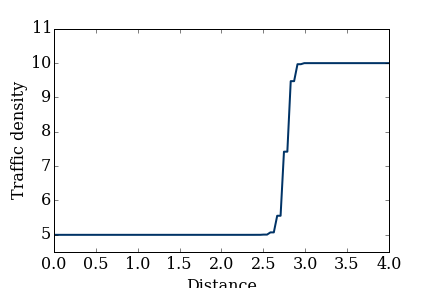
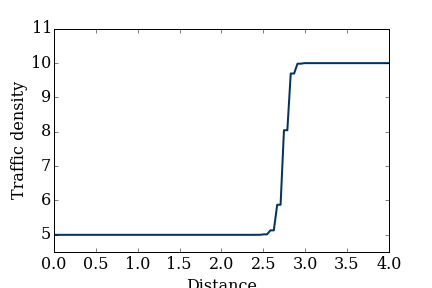
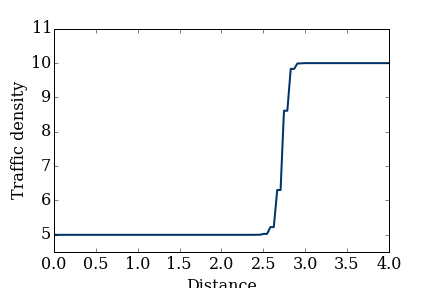
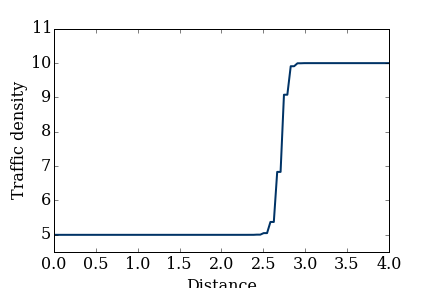
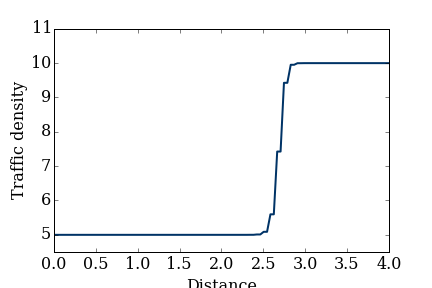
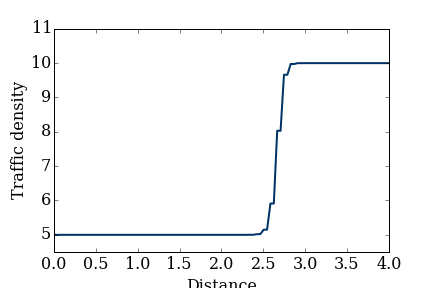
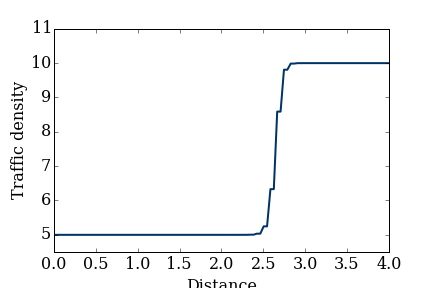
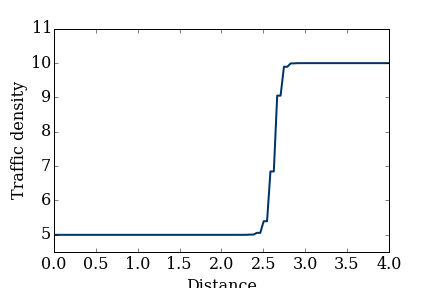
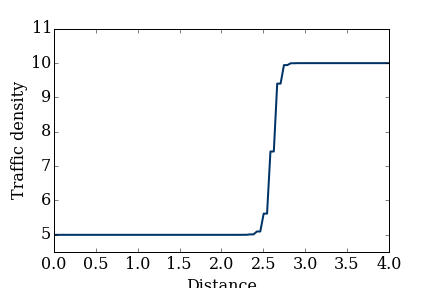
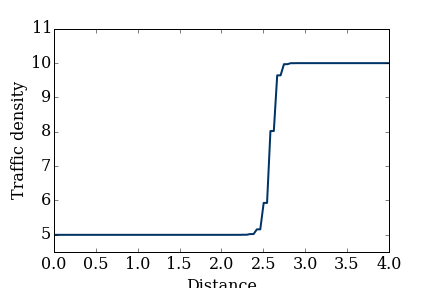
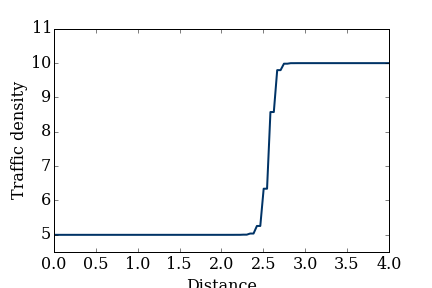
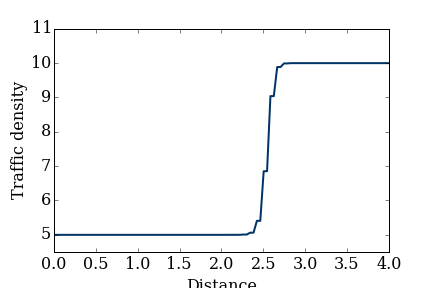
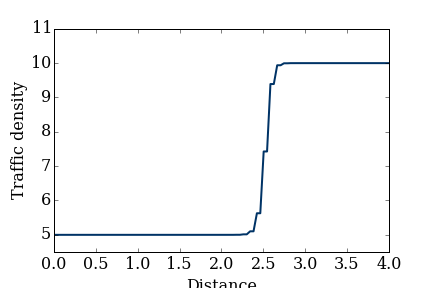
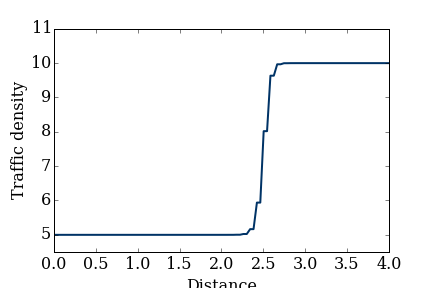
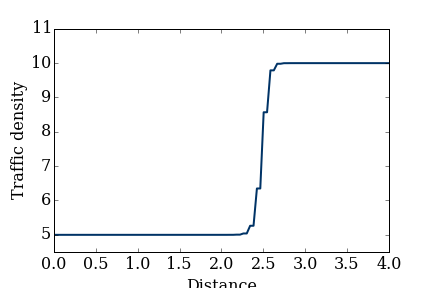
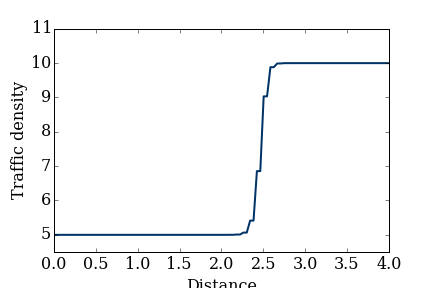
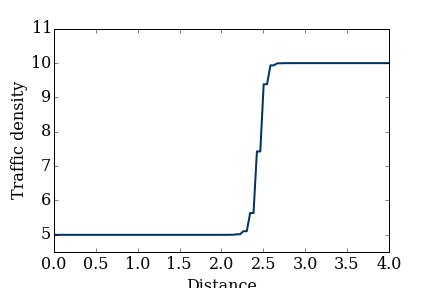
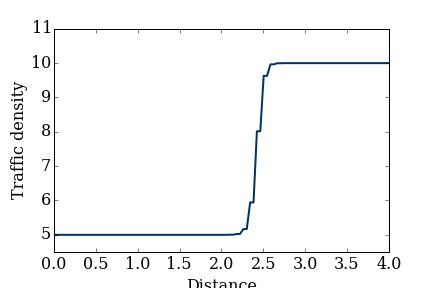
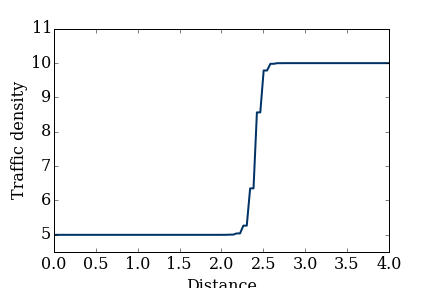
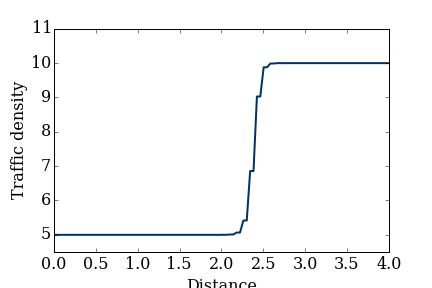

In [3]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

def rho_red_light(nx, rho_max, rho_in):
    """Computes "red light" initial condition with shock

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho

    Parameters
    ----------
    u_max  : float
        Maximum allowed velocity
    rho    : array of floats
        Array with density of cars at every point x
    rho_max: float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 101
nt = 30
dx = 4.0/(nx-2)
rho_in = 5.
rho_max = 10.
V_max = 1.
x = numpy.linspace(0,4,nx-1)
rho = rho_red_light(nx-1, rho_max, rho_in)
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='loop')

def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e : array of float 
        input data
    dx : float 
        spacestep
    
    Returns
    -------
    sigma : array of float 
            minmod slope
    """
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using the Lax-Friedrichs flux,
    RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)

    for t in range(1,nt):
               
        sigma = minmod(rho,dx) #calculate minmod slope

        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.     
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx) #calculate minmod slope
    
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)




fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')
